[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/WoWED-volcano/blob/main/uncertainty_goal_notebook.ipynb)

In [ ]:
# MAKE SURE TO RUN THIS CELL FIRST
# this might take a minute or two
# This cell will install the necessary dependencies and import the necessary modules for the notebook to run in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! rm -rf *
        ! git clone --quiet https://github.com/dominik-strutz/WoWVED tmp
        ! mv tmp/* .
        ! rm -rf tmp
        # only install the first 8 lines of the requirements file to only install the necessary dependencies
        ! head -5 requirements.txt > tmp.txt
        ! mv tmp.txt requirements.txt 
        ! pip install -q -r requirements.txt
        dependencies_installed = True
    from google.colab import output
    output.enable_custom_widget_manager()

In [1]:
import time

import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('helpers/mplstyle.mplstyle')

In [2]:
from helpers.volcano_data_helpers import (
    get_volcano_data,
    fetch_topography_data,
    construct_highly_opinionated_prior
    )

from helpers.plotting_helpers import (
    plot_topography,
    plot_prior_model,
    plot_design_space_dict,
    draw_bounding_box
    )

# General Setup

In [3]:
##################### Choose the volcano ##################### 
VOLCANO_NAME = 'Etna'
###################### Get the data ##  #######################
VOLCANO_DATA = get_volcano_data(VOLCANO_NAME)

################# Choose area of interest ####################
# BOUNDING_BOX = dict(
#     min_lon= VOLCANO_DATA['lon'] - 0.15, # in deg lon
#     max_lon= VOLCANO_DATA['lon'] + 0.15, # in deg lon
#     min_lat= VOLCANO_DATA['lat'] - 0.15, # in deg lat
#     max_lat= VOLCANO_DATA['lat'] + 0.15, # in deg lat
# )
BOUNDING_BOX = dict(
    extent_south = 20.0, # in km
    extent_north = 20.0, # in km
    extent_west  = 20.0, # in km
    extent_east  = 20.0, # in km
)
# the function below allows you to interactively choose the bounding box
# NOTE: the first rectangle you draw will be used as the bounding box, in doubt rerun the cell and try again
# WARNING: even after running other cells, the BOUNDING_BOX variable will still be updated if changed in the map
m, BOUNDING_BOX = draw_bounding_box(VOLCANO_DATA, BOUNDING_BOX)
display(m)

################# Choose the depth range ####################
MAX_DEPTH = 10.0        # km below sea level


Map(center=[37.748, 14.999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

# Topography

In [4]:
try:
    with open('.opentopography.txt', 'r') as file:
        api_key = file.read()
except FileNotFoundError:
    api_key = 'demoapikeyot2022'
    # This is a demo key which should work for a limited number of requests. If you want to use the API more frequently, or if the key stops working, you can get your own key (see https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets for more information).

# API key for the Open Topography API to fetch the digital elevation model
# API key is stored in a separate file .opentopography.txt to avoid accidentally sharing it on GitHub

SURFACE_DATA = fetch_topography_data(VOLCANO_DATA, BOUNDING_BOX, api_key=api_key)

Fetching topography data for SRTM15Plus between 37.56751 and 37.92804 latitude and 14.77253 and 15.22657 longitude
Data loaded from cache


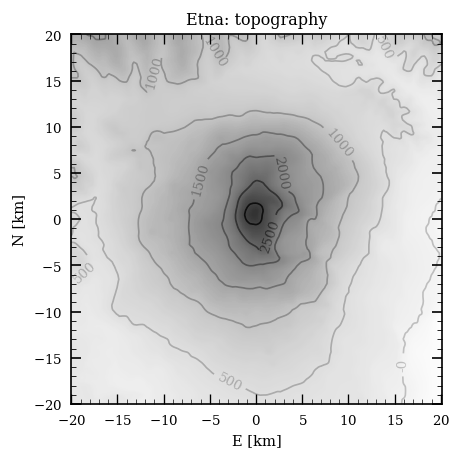

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
plot_topography(ax, SURFACE_DATA['topography'])
ax.set_title(f'{VOLCANO_NAME}: topography')
plt.show()

# Prior Information

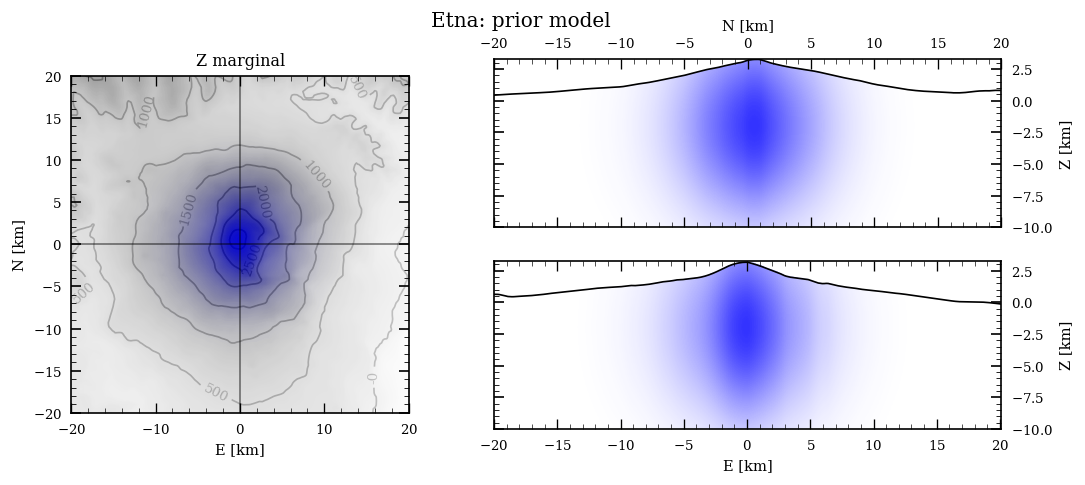

In [6]:
PRIOR_DATA = construct_highly_opinionated_prior(
    SURFACE_DATA, MAX_DEPTH,
    center_location    = (0.0, 0.0, -2.0), # km
    standard_deviation = (5.0, 5.0,  5.0), # km  
    prop2elevation     = True
)

%matplotlib inline
fig, ax_dict = plot_prior_model(PRIOR_DATA, SURFACE_DATA, VOLCANO_DATA)
fig.suptitle(f'{VOLCANO_DATA["Volcano Name"]}: prior model', fontsize=12)

plt.show()

In [7]:
################# Calculate Prior Information ################
from helpers.volcano_data_helpers import calculate_prior_information

prior_information = calculate_prior_information(
    PRIOR_DATA
)
print(f"Prior information: {prior_information:.2f} nats")
# this value in itself is not very informative, but we will make it more informative later on

Prior information: -28.85 nats


# Design Space

We can not plant receivers everywhere and have to therfore restrict the design space. This is of course highly dependent on local circumstance but below we will show a how to implement a number of reasonable design restrictions. This should also make it easy for you to implement your own.

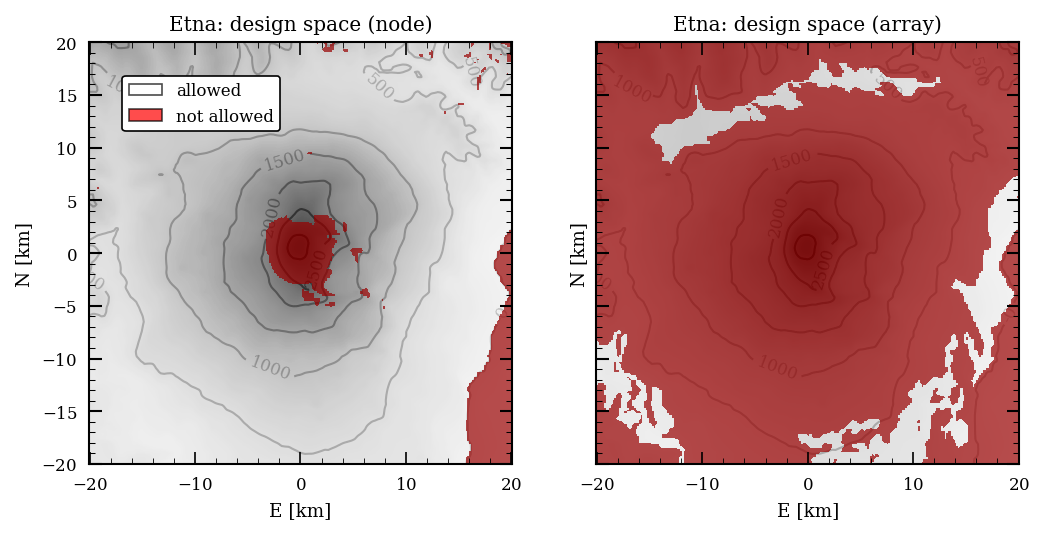

In [8]:
from helpers.design_space_helpers import construct_design_space

design_space_node = construct_design_space(
    SURFACE_DATA,
    max_incline             = 20.0,      # degrees,
    exclude_below_sea_level = True,
    # only add a safety margin if the last eruption was within the last 10 years
    safety_margin           = 3.0 if int(VOLCANO_DATA['Last Known Eruption']) >= time.localtime().tm_year-10 else 0.0, # km
    )

design_space_array = construct_design_space(
    SURFACE_DATA,
    max_incline             = 3.0,         # degrees,
    exclude_below_sea_level = True,
    # only add a safety margin if the last eruption was within the last 10 years
    safety_margin           = 3.0 if int(VOLCANO_DATA['Last Known Eruption']) >= time.localtime().tm_year-10 else 0.0,  # km,
    min_area                = 10           # km^2 minimum area of the connected region
    )

design_space_dict = dict(
    node=design_space_node,
    array=design_space_array,
)

%matplotlib inline
plot_design_space_dict(design_space_dict, SURFACE_DATA, VOLCANO_DATA);

# Forward Solver

Here we assume a simple homogenous velocity model Therefore both travel times and arrival angles can be calculated analytically. It is also possible to use a more complex forward solver to take a gradient model or a complex velocity model into account, but this is computationally more expensive. In many cases, the simple forward solver is sufficient since there is no information about the subsurface available anyway.

---
#### !!! Warning !!!

We assume here that the geometry of the volcano is a [convex set](https://en.wikipedia.org/wiki/Convex_set) and therefore the straight rays between source and receiver do not intersect the topography. This is typically true on the large scale, but care must be taken when applying this workflow for example in a crater or caldera where the geometry is not a convex set. In this case, the forward solver must be adapted to take the topography into account.

---

Data Types:
* 'PS_diff': Difference between P and S-wave arrival time
* 'ASL': Amplitude of the S-wave
* 'array': Array measurment: backazimuth and apparent velocity

In [9]:
from helpers.forward_function_helpers import Forward_Function

forward_function = Forward_Function({
    'arrival_p': {
        'v_hom'   : 3500.0,  # m/s
        'std_obs' : 0.01,    # absolute uncertainty of the observed arrival time
        'std_vel' : 0.1,     # characteristic relative uncertainty of the velocity model
    },
    'amplitude_s': {
        'v_hom'   : 3500.0/np.sqrt(3),  # m/s
        'std_vel' : 0.1,     # characteristic relative uncertainty of the velocity model
        'f'       : 5.0,     # Hz
        'Q'       : 50.0,    # quality factor
        'std_Q'   : 10.0,    # characteristic relative uncertainty of the quality factor
    },
    'array': {
        'v_hom'   : 3500.0,  # m/s
        'std_baz' : 10.0,     # degrees
        # 'std_inc' : 20.0,     # degrees
        'deg_std' : True,
        'baz_only': True,
        'correct_for_topography': True,
    },},
    surface_data=SURFACE_DATA,
)

test_design = [
    [['arrival_p'],                         np.array([0.0, 0.0, 0.0])*1e3,],
    [['amplitude_s'],                       np.array([1.0, 0.0, 0.0])*1e3,],
    [['array'],                             np.array([2.0, 0.0, 0.0])*1e3,],
    [['arrival_p', 'amplitude_s'],          np.array([3.0, 0.0, 0.0])*1e3,],
    [['arrival_p', 'amplitude_s', 'array'], np.array([4.0, 0.0, 0.0])*1e3,],
]

# Experimental Design (Design Criterion)

In [10]:
from helpers.experimental_design_helpers import (
    DN_method,
    NMC_method)

dn_method = DN_method(
    forward_function,
    PRIOR_DATA,
    n_model_samples=int(1e3)
)

nmc_method = NMC_method(
    forward_function,
    PRIOR_DATA,
    n_model_samples=int(1e3),
)

# Experimental Design (Design Optimisation)

In [11]:
from helpers.experimental_design_helpers import Design_Optimisation

# you can easily add already existing stations here to the preexisting_design
#TODO: for now it only works in local coordinates
# preexisting_design = (
#     (['tt', 'asl',], np.array(
#         [ 10.0, 10.0, get_elevation(np.array([ 10.0, 10.0,]), SURFACE_DATA)])),
# )
# for now we will use no preexisting design
preexisting_design = None


design_optimisation = Design_Optimisation(
    dn_method,
    SURFACE_DATA,
    design_space_dict,
    preexisting_design=preexisting_design
)

In [12]:
import os
import pickle

target_uncertainty = 400.0  # m
N_max = 11

num_generations = 500


design_list = []
info_list = []
std_list = []
eig_list = []

results_filename = f'data/results/uncertainty_goal/{target_uncertainty:.0f}m_{VOLCANO_NAME}_gen_{num_generations}.pkl'

if not os.path.exists(results_filename):
    
    number_of_stations = 1
    for i in range(N_max):

        available_stations = dict(n_node=number_of_stations,)


        best_design, info = design_optimisation.get_optimal_design(
            available_stations=available_stations,
                optimisation_algorithm='genetic',
                optimisation_kwargs=dict(
                    num_generations=500,
                    num_parents_mating=4,
                    plot_fitness=True,
                    random_seed=0,
                )
        )
        
        torch.manual_seed(0)
        eig = nmc_method(best_design)
        post_information = eig + prior_information

        k = 3
        std = np.exp((-post_information - k/2 * (1 + np.log(2*np.pi))) / (0.5 * k * 2))
        
        design_list.append(best_design)
        info_list.append(info)
        std_list.append(std)
        eig_list.append(eig)
        
        print(f"Number of stations: {number_of_stations}")
        print(f"Posterior standard deviation: {std:.2f} m")
        print('===========================================================')
        
        if std < target_uncertainty:
            break
        else:
            number_of_stations += 1
            
            
    std_list = np.array(std_list)
    eig_list = np.array(eig_list)

    # save the results
    results = dict(
        design_list=design_list,
        std_list=std_list,
        eig_list=eig_list,
    )

    if not os.path.exists('data/results/uncertainty_goal/'):
        os.makedirs('data/results/uncertainty_goal/')

    with open(results_filename, 'wb') as file:
        pickle.dump(results, file)
        
else:
    with open(results_filename, 'rb') as file:
        results = pickle.load(file)
        
    design_list = results['design_list']
    std_list = results['std_list']
    eig_list = results['eig_list']

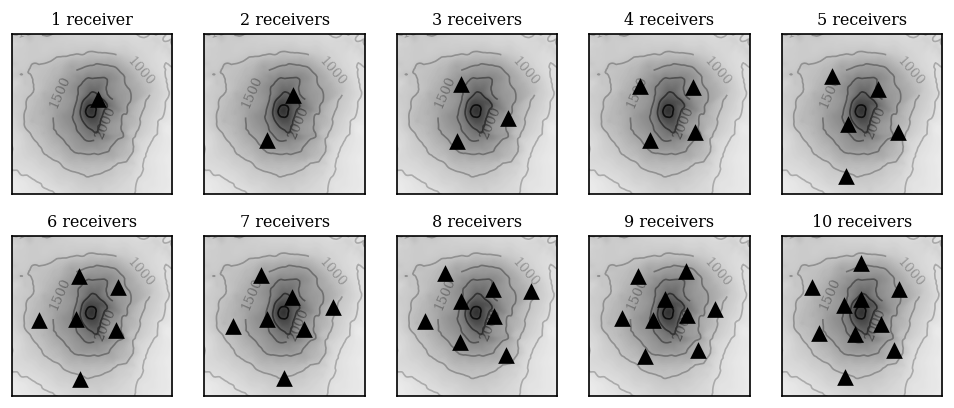

In [13]:
%matplotlib inline

indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_design_list = [design_list[i] for i in indices]

# fig, ax_list = plt.subplots(1, len(plot_design_list), figsize=(len(plot_design_list)*2, 2), dpi=120)
max_cols = 5 
n_rows = len(plot_design_list) // max_cols

fig, ax_list = plt.subplots(n_rows, max_cols, figsize=(max_cols*2, n_rows*2), dpi=120)
ax_list = ax_list.flatten()

fig.set_facecolor('white')

# derive color list from the viridis colormap
from matplotlib.cm import viridis
color_list = viridis(np.linspace(0, 1, len(plot_design_list)))

for i, design in enumerate(plot_design_list):
    
    ax = ax_list if len(plot_design_list) == 1 else ax_list[i]
    
    plot_topography(ax, SURFACE_DATA['topography'])

    for sta_type, sta_data in design:
        ax.scatter(
            sta_data[0]*1e-3,
            sta_data[1]*1e-3,
            s=100 if 'array' in sta_type else 100,
            marker='x' if 'array' in sta_type else '^',
            # color=color_list[i],
            color='black',
            linewidth=4 if 'array' in sta_type else 0
        )

    if i ==0:
        ax.set_title(f"{len(design)} receiver")
    else:
        ax.set_title(f"{len(design)} receivers")
                    
    ax.set_aspect("equal")

    ax.set_xlabel(None)
    ax.set_ylabel(None)

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    
fig.savefig(f'figures/{VOLCANO_NAME}_designs.png', bbox_inches='tight', dpi=300)
fig.savefig(f'figures/{VOLCANO_NAME}_designs.pdf', bbox_inches='tight', dpi=300)

plt.show()

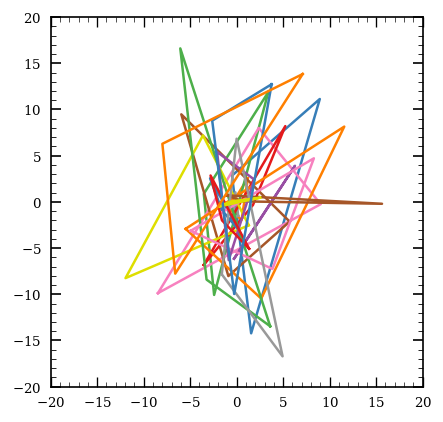

In [14]:
# use torch to plot 100 sobol designs for three receivers

from torch.quasirandom import SobolEngine

N_draws_sobol = 20
N_receivers = 3
    
design_samples = torch.zeros(N_draws_sobol, N_receivers, 2)
for i in range(N_draws_sobol):
    design_samples[i] = SobolEngine(
        dimension=2, scramble=True,
        seed=i).draw(N_receivers)

design_samples -= 0.5

torch.manual_seed(0)

design_samples = design_samples * torch.rand(N_draws_sobol, 2)[:, None] * 2 * 20

fig, ax = plt.subplots(figsize=(4, 4), dpi=120)

for i in range(N_draws_sobol):
    # ax.scatter(
    #     design_samples[i, :, 0], design_samples[i, :, 1],
    #     s=30, zorder=1)
    
    ax.plot(
        list(design_samples[i, :, 0]) + [design_samples[i, 0, 0]],
        list(design_samples[i, :, 1]) + [design_samples[i, 0, 1]],
        zorder=1, linewidth=1.5, alpha=1.0)
        

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)


plt.show()
    

In [15]:
import xarray as xr
from tqdm.autonotebook import tqdm

N_rec_max = len(design_list[-1])

N_draws_sobol = 1000

filename_sobol = f'data/results/uncertainty_goal/sobol_{VOLCANO_NAME}_nrec_{N_rec_max}_draws_{N_draws_sobol}.npz'

if not os.path.exists(filename_sobol):
    
    sobol_eig = np.zeros((N_rec_max, N_draws_sobol))
    sobol_std = np.zeros((N_rec_max, N_draws_sobol))

    for n_rec in tqdm(range(1, N_rec_max+1)):
        design_samples = torch.zeros(N_draws_sobol, n_rec, 2)
        for i in range(N_draws_sobol):
            design_samples[i] = SobolEngine(
                dimension=2, scramble=True,
                seed=i).draw(n_rec)

        design_samples -= 0.5

        torch.manual_seed(0)
        design_samples = design_samples * torch.rand(N_draws_sobol, n_rec, 2) * 2 * 20e3
        
        design_samples = design_samples.numpy()
        
        # add elevation
        elevations = SURFACE_DATA['topography'].interp(
            E=xr.DataArray(design_samples[:, :, 0].flatten(), dims='interpolation'),
            N=xr.DataArray(design_samples[:, :, 1].flatten(), dims='interpolation')
            , method='linear'   
        ).values.reshape(N_draws_sobol, n_rec)
        
        design_samples = np.concatenate([design_samples, elevations[..., None]], axis=-1)

        designs = [[(('arrival_p', 'amplitude_s'), d) for d in d_sample] for d_sample in design_samples]
            
        for i, d in enumerate(designs):        
            eig = nmc_method(d)
            sobol_eig[n_rec-1, i] = eig
            
            post_information = eig + prior_information
            k = 3
            std = np.exp((-post_information - k/2 * (1 + np.log(2*np.pi))) / (0.5 * k * 2))
            
            sobol_std[n_rec-1, i] = std
            
    sobol_eig = np.array(sobol_eig)
    sobol_std = np.array(sobol_std)
    
    results = dict(
        sobol_eig=sobol_eig,
        sobol_std=sobol_std,
    )
    
    np.savez(filename_sobol, **results)
    
else:
    
    results = np.load(filename_sobol)
    sobol_eig = results['sobol_eig']
    sobol_std = results['sobol_std']

In [16]:
N_rec_max = len(design_list[-1])

N_draws_random = 1000

# random designs

random_eig = np.zeros((N_rec_max, N_draws_random))
random_std = np.zeros((N_rec_max, N_draws_random))

filename_random = f'data/results/uncertainty_goal/random_{VOLCANO_NAME}_nrec_{N_rec_max}_draws_{N_draws_random}.npz'

if not os.path.exists(filename_random):
    random_eig = np.zeros((N_rec_max, N_draws_random))
    random_std = np.zeros((N_rec_max, N_draws_random))
    
    for n_rec in tqdm(range(1, N_rec_max+1)):
        for i in range(N_draws_random):
            
            np.random.seed(i)
            design_samples = np.random.rand(n_rec, 2) * 2 * 19.9e3 - 19.9e3
                        
            elevations = SURFACE_DATA['topography'].interp(
                E=xr.DataArray(design_samples[:, 0], dims='interpolation'),
                N=xr.DataArray(design_samples[:, 1], dims='interpolation')
                , method='linear'   
            ).values

            design_samples = np.concatenate([design_samples, elevations[..., None]], axis=-1)

            designs = [[(('arrival_p', 'amplitude_s'), d) for d in design_samples]]
                        
            for d in designs:        
                eig = nmc_method(d)
                random_eig[n_rec-1, i] = eig

                post_information = eig + prior_information
                k = 3
                std = np.exp((-post_information - k/2 * (1 + np.log(2*np.pi))) / (0.5 * k * 2))

                random_std[n_rec-1, i] = std

    random_eig = np.array(random_eig)
    random_std = np.array(random_std)
    
    results = dict(
        random_eig=random_eig,
        random_std=random_std,
    )
    
    np.savez(filename_random, **results)
    
else:
    
    results = np.load(filename_random)
    random_eig = results['random_eig']
    random_std = results['random_std']

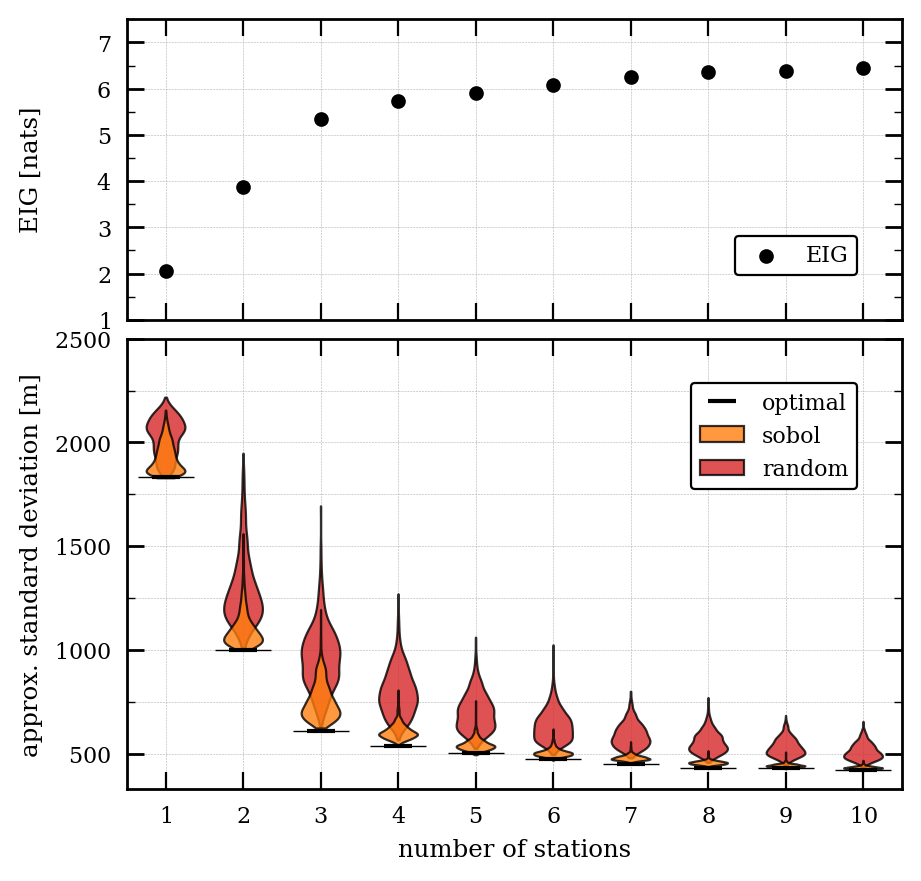

In [17]:
fig, ax_list = plt.subplots(
    2, 1,
    figsize=(5, 5), dpi=200, sharex=True, height_ratios=[2, 3], gridspec_kw={'hspace': 0.05})

std_list_plot = std_list[:10]
eig_list_plot = eig_list[:10]
x_values = np.arange(1, len(std_list_plot)+1)

# plot std on right y axis and information on left y axis

ax = ax_list[1]

ax.plot(
    x_values, std_list_plot,
    color='k', label='optimal', linestyle='-', linewidth=0, solid_joinstyle='bevel', zorder=11,
    alpha=1.0, marker='_', markersize=10, markeredgewidth=1.5)

ax.plot(
    x_values, std_list_plot,
    color='k', linestyle='-', linewidth=0, solid_joinstyle='bevel', zorder=11,
    alpha=1.0, marker='_', markersize=20, markeredgewidth=0.5)


# ax.set_ylabel(r'$\bar{\sigma} [m]$')
ax.set_ylabel(r'approx. standard deviation [m]')


ax.set_xticks(x_values)

# ax.axhline(y=target_uncertainty, color='r', linestyle='--', linewidth=1, zorder=-1)

# violin plot for sobol_std and sobol_eig
random_parts = ax.violinplot(
    random_std[:len(std_list_plot)].T, positions=x_values[:len(std_list_plot)],
    widths=0.5, showmeans=False, showmedians=False, showextrema=False)
for pc in random_parts['bodies']:
    pc.set_facecolor('tab:red')
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
    pc.set_zorder(10)
    
    # m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)


sobol_parts = ax.violinplot(
    sobol_std[:len(std_list_plot)].T, positions=x_values[:len(std_list_plot)],
    widths=0.5, showmeans=False, showmedians=False, showextrema=False)
for pc in sobol_parts['bodies']:
    pc.set_facecolor('tab:orange')
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
    pc.set_zorder(10)
    
    # m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)


ax.set_xlim(0.5, 10.5)
ax.set_xticks(x_values)
ax.set_xticks([], minor=True)
ax.set_xlabel('number of stations')

handles, labels = ax.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()
# handles += handles2
# labels += labels2

handles += [sobol_parts['bodies'][0], random_parts['bodies'][0]]
labels += ['sobol', 'random']

ax.set_yticks(np.arange(500, 2600, 500))
ax.set_yticks(np.arange(500, 2600, 250), minor=True)
# ax.set_yticks(std_list_plot)
# ax.set_yticklabels([f"{std:.0f}" for std in std_list_plot])
# ax.set_yticks([], minor=True)

# y tick grid
ax.grid(axis='y', linestyle='--', linewidth=0.2, zorder=-40, which='both')
ax.grid(axis='x', linestyle='--', linewidth=0.2, zorder=-40, which='major')

ax.legend(
    handles, labels,
    loc='upper right', facecolor='white')

ax2 = ax_list[0]

ax2.scatter(
    x_values, eig_list_plot,
    color='black', label='EIG', marker='o', zorder=11, s=20)

ax2.set_ylabel('EIG [nats]')
ax2.legend(loc='lower right', facecolor='white')

ax2.set_ylim(1, 7)
ax2.set_yticks(np.arange(1, 7+1,  1))
ax2.set_yticks(np.arange(1, 7+1,  0.5), minor=True)

ax2.grid(axis='y', linestyle='--', linewidth=0.2, zorder=-40, which='major')
ax2.grid(axis='x', linestyle='--', linewidth=0.2, zorder=-40, which='major')

# random_parts = ax2.violinplot(
#     -random_eig[:len(std_list_plot)].T, positions=x_values[:len(std_list_plot)],
#     widths=0.5, showmeans=False, showmedians=False, showextrema=False)
# for pc in random_parts['bodies']:
#     pc.set_facecolor('tab:red')
#     pc.set_edgecolor('black')
#     pc.set_alpha(0.8)
#     pc.set_zorder(10)
    
# sobol_parts = ax2.violinplot(
#     -sobol_eig[:len(std_list_plot)].T, positions=x_values[:len(std_list_plot)],
#     widths=0.5, showmeans=False, showmedians=False, showextrema=False)

# for pc in sobol_parts['bodies']:
#     pc.set_facecolor('tab:orange')
#     pc.set_edgecolor('black')
#     pc.set_alpha(0.8)
#     pc.set_zorder(10)
    
fig.align_ylabels(ax_list)

fig.savefig('figures/uncertainty_goal.pdf', bbox_inches='tight', dpi=400)
fig.savefig('figures/uncertainty_goal.png', bbox_inches='tight', dpi=400)

plt.show()